In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import collections

from torch.utils.data import DataLoader, random_split

# check what device will be used (MPS on Mac if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [49]:
# convert to tensor + normalize [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# loading the FashionMNIST  (train + test)
train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

In [50]:
# split the original set into train/val (cca 90/10)
train_size = int(0.9 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])

print("train samples:", len(train_data))
print("val samples:  ", len(val_data))
print("test samples: ", len(test_dataset))

train samples: 54000
val samples:   6000
test samples:  10000


In [51]:
# dataloaders for train / val / test splits
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# classes in FashionMNIST
class_names = train_dataset.classes
print("Classes:", class_names)

# basic dataset info
print("Train set size:", len(train_dataset))
print("Test set size: ", len(test_dataset))

# raw image shape
print("Example raw image shape:", train_dataset.data[0].shape)

# convert raw pixels (0–255) to floats in [0,1] for statistics
data_np = train_dataset.data.numpy().astype(np.float32) / 255.0

print("Pixel mean:", data_np.mean())
print("Pixel std: ", data_np.std())

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Train set size: 60000
Test set size:  10000
Example raw image shape: torch.Size([28, 28])
Pixel mean: 0.2860402
Pixel std:  0.3530239


Class distribution:
0 - T-shirt/top: 6000
1 - Trouser: 6000
2 - Pullover: 6000
3 - Dress: 6000
4 - Coat: 6000
5 - Sandal: 6000
6 - Shirt: 6000
7 - Sneaker: 6000
8 - Bag: 6000
9 - Ankle boot: 6000


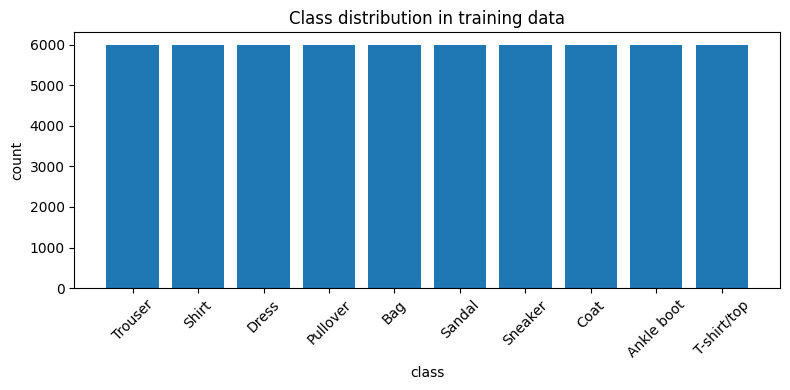

In [89]:
# info how balanced the classes are
label_counts = collections.Counter(train_dataset.targets.numpy())

print("Class distribution:")
for idx, cnt in sorted(label_counts.items()):
    print(f"{idx} - {class_names[idx]}: {cnt}")

# bar plot - class distribution
plt.figure(figsize=(8, 4))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(list(label_counts.keys()), class_names, rotation=45)
plt.ylabel("count")
plt.xlabel("class")
plt.title("Class distribution in training data")
plt.tight_layout()
plt.show()

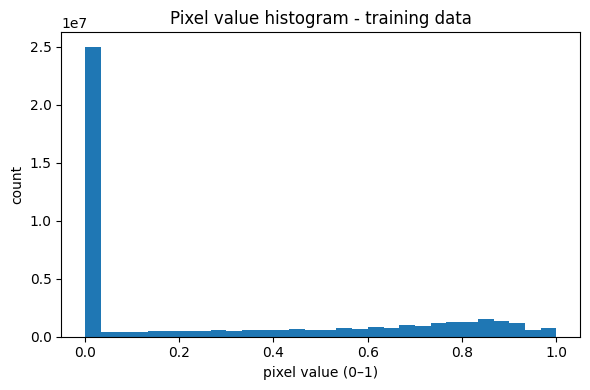

In [90]:
# distribution of pixel values
plt.figure(figsize=(6, 4))
plt.hist(data_np.flatten(), bins=30)
plt.xlabel("pixel value (0–1)")
plt.ylabel("count")
plt.title("Pixel value histogram - training data")
plt.tight_layout()
plt.show()

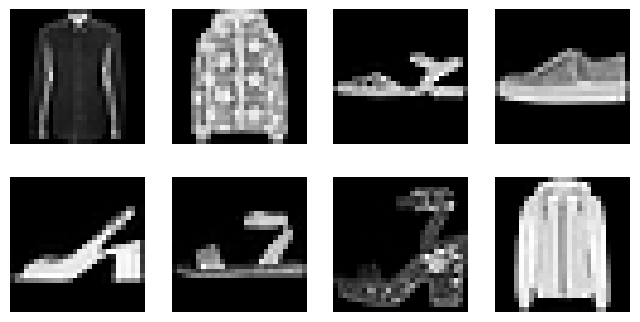

In [61]:
# preview of training samples after normalization
batch = next(iter(train_loader))
example_data, example_targets = batch

plt.figure(figsize=(8, 4))
for i in range(8):

    img = example_data[i][0] * 0.5 + 0.5
    
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.show()

In [64]:
# convolutional autoencoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        
        # encoder part (conv. layers + linear projection)
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )
        
        # decoder (linear + conv. transpose layers)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()   # output in [-1, 1]
        )
        
    # forward pass
    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat

In [66]:
# training loop for the autoencoder
def train_autoencoder(latent_dim, num_epochs=10):

    # create model, optimizer, loss function
    model = Autoencoder(latent_dim=latent_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    tr_losses, val_losses = [], []

    for ep in range(num_epochs):

        # training phase
        model.train()
        tr_loss_sum = 0.0

        for imgs, _ in train_loader:
            imgs = imgs.to(device)

            out = model(imgs)
            loss = loss_fn(out, imgs)

            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_loss_sum += loss.item()

        tr_avg = tr_loss_sum / len(train_loader)
        tr_losses.append(tr_avg)

        # validation phase
        model.eval()
        val_loss_sum = 0.0

        # no gradient during validation
        with torch.no_grad():
            for imgs, _ in val_loader:
                imgs = imgs.to(device)
                val_loss_sum += loss_fn(model(imgs), imgs).item()

        val_avg = val_loss_sum / len(val_loader)
        val_losses.append(val_avg)

        # log for monitoring
        print(f"[z={latent_dim}] epoch {ep+1}/{num_epochs} | train {tr_avg:.4f} | val {val_avg:.4f}")

    return model, tr_losses, val_losses

In [71]:
# latent space sizes
latent_dims = [8, 16, 32, 64, 128, 256]
res_dict = {}

for z in latent_dims:
    print(f"\n....training model with latent space size = {z} ")
    model, tr_l, val_l = train_autoencoder(z, num_epochs=10)
    res_dict[z] = (model, tr_l, val_l)


....training model with latent space size = 8 
[z=8] epoch 1/10 | train 0.2088 | val 0.0967
[z=8] epoch 2/10 | train 0.0889 | val 0.0832
[z=8] epoch 3/10 | train 0.0806 | val 0.0779
[z=8] epoch 4/10 | train 0.0765 | val 0.0749
[z=8] epoch 5/10 | train 0.0738 | val 0.0724
[z=8] epoch 6/10 | train 0.0719 | val 0.0710
[z=8] epoch 7/10 | train 0.0704 | val 0.0695
[z=8] epoch 8/10 | train 0.0691 | val 0.0683
[z=8] epoch 9/10 | train 0.0679 | val 0.0677
[z=8] epoch 10/10 | train 0.0670 | val 0.0664

....training model with latent space size = 16 
[z=16] epoch 1/10 | train 0.1188 | val 0.0684
[z=16] epoch 2/10 | train 0.0629 | val 0.0589
[z=16] epoch 3/10 | train 0.0567 | val 0.0547
[z=16] epoch 4/10 | train 0.0534 | val 0.0521
[z=16] epoch 5/10 | train 0.0511 | val 0.0505
[z=16] epoch 6/10 | train 0.0494 | val 0.0487
[z=16] epoch 7/10 | train 0.0482 | val 0.0479
[z=16] epoch 8/10 | train 0.0472 | val 0.0469
[z=16] epoch 9/10 | train 0.0464 | val 0.0460
[z=16] epoch 10/10 | train 0.0457 | va

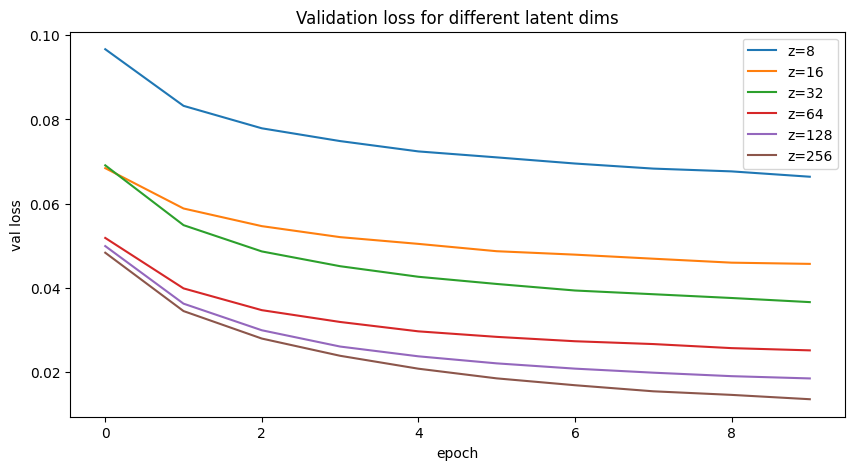

In [74]:
# validation losses plot for different latent sizes
plt.figure(figsize=(10, 5))

for z in latent_dims:
    _, _, v_loss = res_dict[z]
    plt.plot(v_loss, label=f"z={z}")

plt.xlabel("epoch")
plt.ylabel("val loss")
plt.title("Validation loss for different latent dims")
plt.legend()
plt.show()

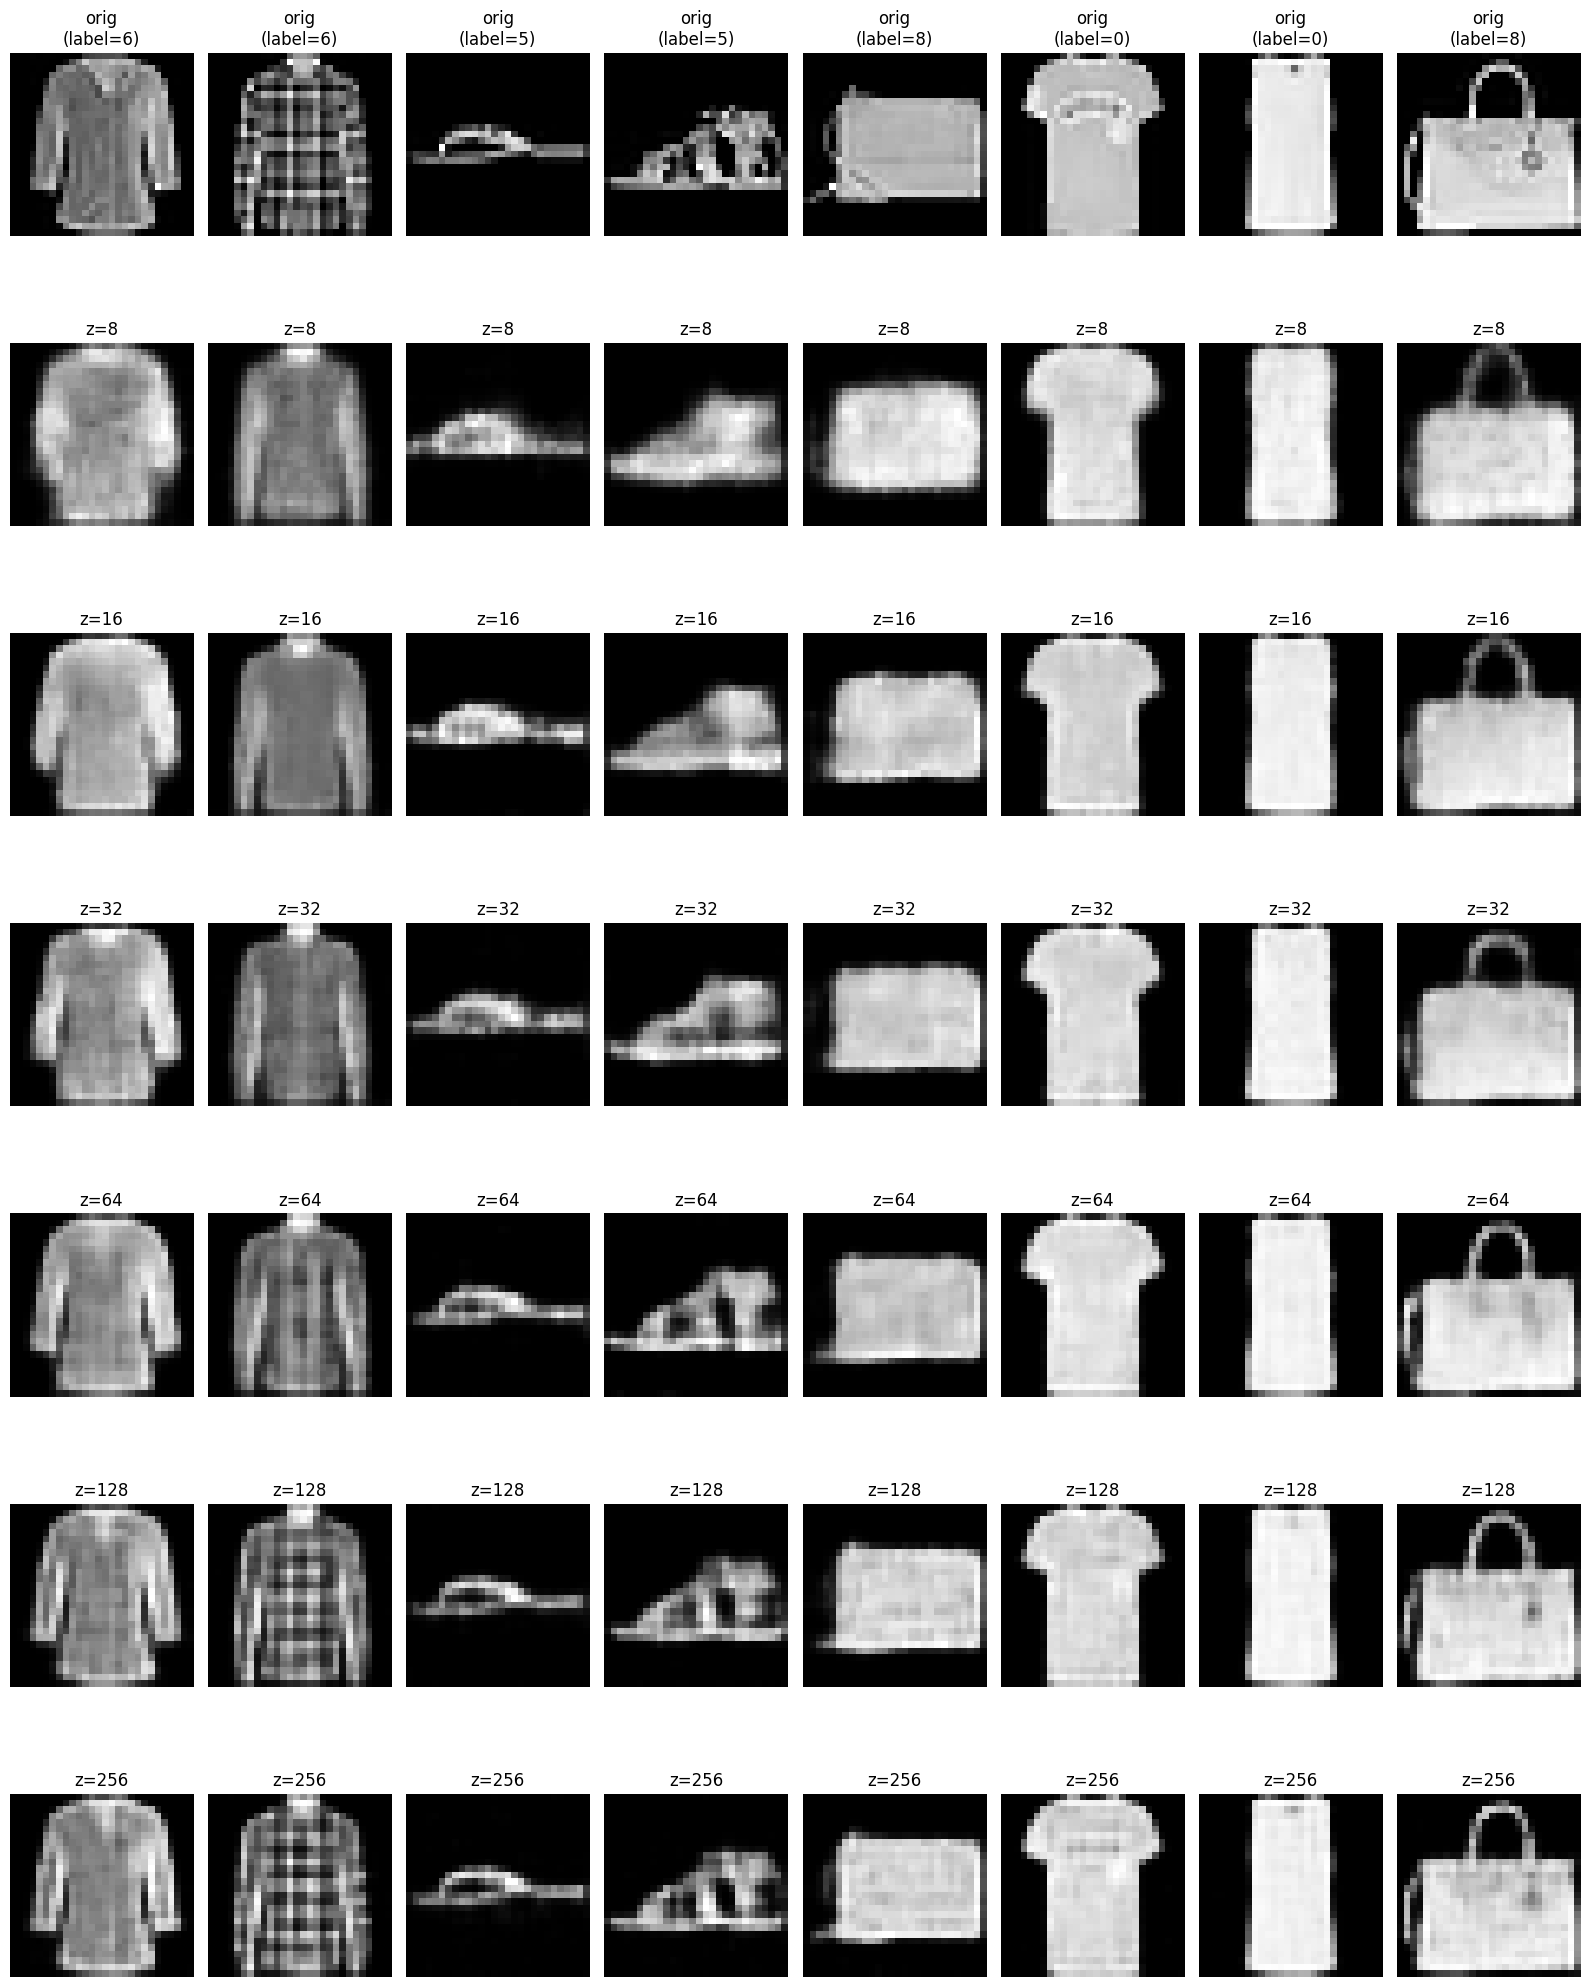

In [76]:
# few classes and some samples from the test set
# (0–9 classes: t-shirt, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot)
wanted = [8, 0, 6, 5]        # few classes to show
n_per_class = 2

sel_imgs = []
sel_labels = []

# counter for images taken per class
cls_count = {c: 0 for c in wanted}

# loop through the test set + collection
for img, lbl in test_dataset:
    lbl = int(lbl)
    if lbl in wanted and cls_count[lbl] < n_per_class:
        sel_imgs.append(img)
        sel_labels.append(lbl)
        cls_count[lbl] += 1


    if all(cls_count[c] == n_per_class for c in wanted):
        break

# stack to tensor + move to device
sel_imgs = torch.stack(sel_imgs).to(device)
sel_labels = torch.tensor(sel_labels)
n_imgs = len(sel_imgs)


# show original images + reconstructions for different latent dims


plt.figure(figsize=(n_imgs * 2, 3 * (len(latent_dims) + 1)))

for r, z in enumerate(latent_dims):
    model, _, _ = res_dict[z]
    model.eval()

    with torch.no_grad():
        out = model(sel_imgs)

    for c in range(n_imgs):

        # first row - original images
        if r == 0:
            plt.subplot(len(latent_dims) + 1, n_imgs, c + 1)
            plt.imshow(sel_imgs[c].cpu().squeeze(), cmap="gray")
            plt.title(f"orig\n(label={sel_labels[c].item()})")
            plt.axis("off")

        # other rows - reconstructions for different latent sizes
        plt.subplot(len(latent_dims) + 1, n_imgs, (r + 1) * n_imgs + c + 1)
        plt.imshow(out[c].cpu().squeeze(), cmap="gray")
        plt.title(f"z={z}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [77]:
# MSE check on the test set for each latent dim
test_losses = {}
mse = nn.MSELoss()

for z in latent_dims:
    model, _, _ = res_dict[z]
    model.eval()

    total = 0.0
    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            total += mse(out, imgs).item()

    avg = total / len(test_loader)
    test_losses[z] = avg

    print(f"z={z}  ->  test MSE = {avg:.4f}")

z=8  ->  test MSE = 0.0674
z=16  ->  test MSE = 0.0465
z=32  ->  test MSE = 0.0373
z=64  ->  test MSE = 0.0256
z=128  ->  test MSE = 0.0187
z=256  ->  test MSE = 0.0137


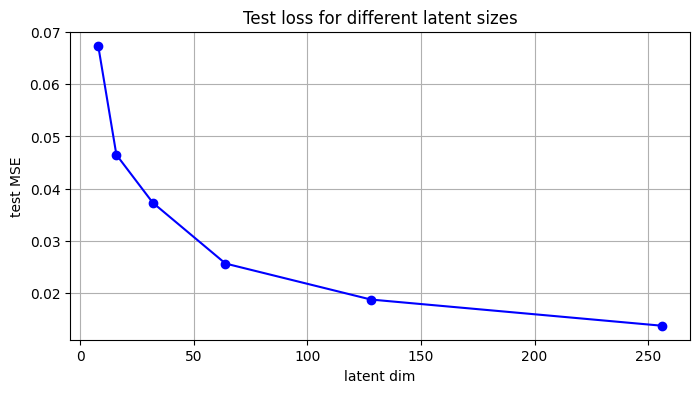

In [88]:
# plot - test loss for different latent sizes
plt.figure(figsize=(8, 4))

plt.plot(
    list(test_losses.keys()),
    list(test_losses.values()),
    marker="o",
    color="blue"
)

plt.xlabel("latent dim")
plt.ylabel("test MSE")
plt.title("Test loss for different latent sizes")
plt.grid(True)

plt.show()

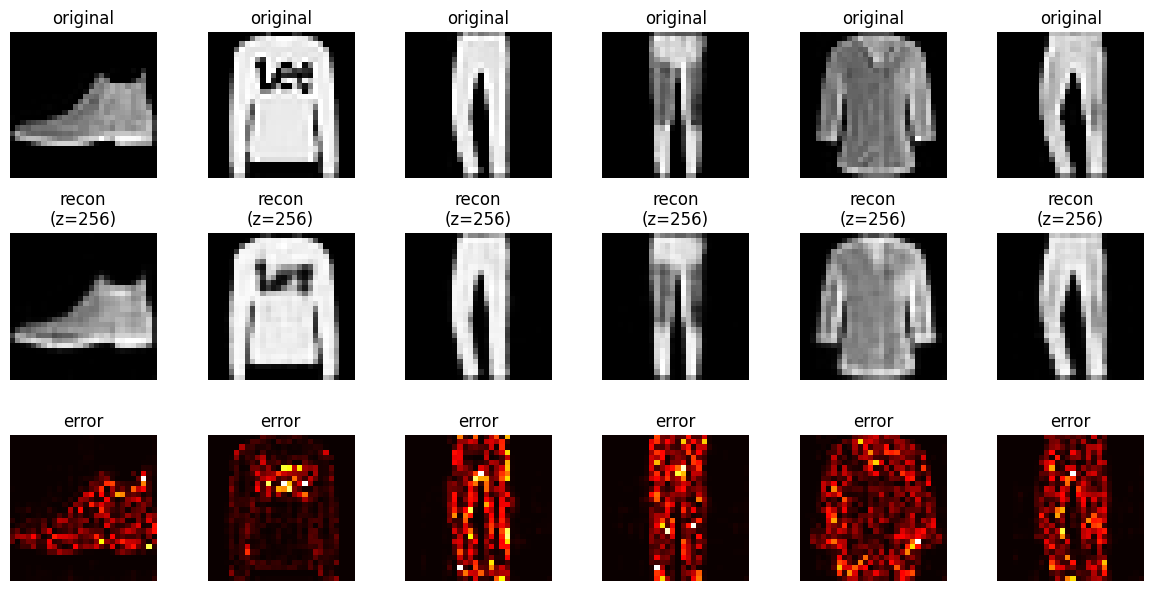

In [95]:
# error maps visualization for a selected latent size
import torch.nn.functional as F

chosen_z = 256   # 8, 16, 32, ...

model, _, _ = res_dict[chosen_z]
model.eval()

# small batch from the test loader
imgs, _ = next(iter(test_loader))
imgs = imgs.to(device)

with torch.no_grad():
    out = model(imgs)

# absolute reconstruction error
err = torch.abs(imgs - out)

plt.figure(figsize=(12, 6))

# show first few samples
for i in range(6):

    # original
    plt.subplot(3, 6, i + 1)
    plt.imshow(imgs[i].cpu().squeeze(), cmap="gray")
    plt.title("original")
    plt.axis("off")

    # reconstruction
    plt.subplot(3, 6, i + 7)
    plt.imshow(out[i].cpu().squeeze(), cmap="gray")
    plt.title(f"recon\n(z={chosen_z})")
    plt.axis("off")

    # error map
    plt.subplot(3, 6, i + 13)
    plt.imshow(err[i].cpu().squeeze(), cmap="hot")
    plt.title("error")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# SSIM for each latent size
from skimage.metrics import structural_similarity as ssim

ssim_scores = {}

for z in latent_dims:
    model, _, _ = res_dict[z]
    model.eval()

    score_sum = 0.0
    n_samples = 0

    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)

            # convert back to numpy in [0,1] for the SSIM function
            orig_np = imgs.cpu().numpy() * 0.5 + 0.5
            rec_np  = out.cpu().numpy()   * 0.5 + 0.5

            # SSIM per-sample
            for i in range(len(orig_np)):
                s = ssim(orig_np[i, 0], rec_np[i, 0], data_range=1.0)
                score_sum += s
                n_samples += 1

    ssim_scores[z] = score_sum / n_samples
    print(f"z={z} | SSIM={ssim_scores[z]:.4f}")

z=8 | SSIM=0.6522
z=16 | SSIM=0.7334
z=32 | SSIM=0.7755
z=64 | SSIM=0.8386
z=128 | SSIM=0.8802
z=256 | SSIM=0.9107


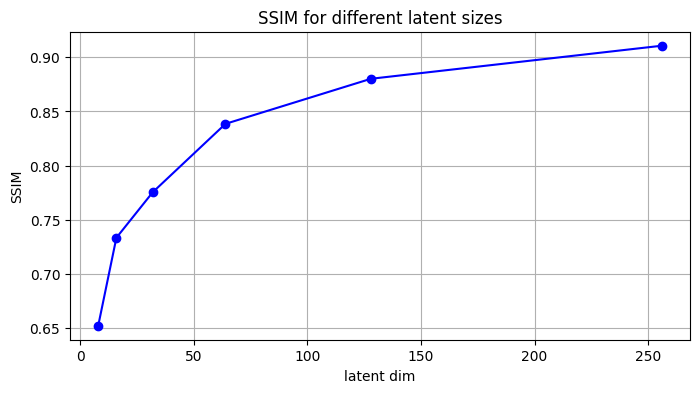

In [ ]:
# plot - SSIM vs latent dim
plt.figure(figsize=(8, 4))

plt.plot(
    list(ssim_scores.keys()),
    list(ssim_scores.values()),
    marker="o",
    color="blue"
)

plt.xlabel("latent dim")
plt.ylabel("SSIM")
plt.title("SSIM for different latent sizes")
plt.grid(True)

plt.show()